# Tutorial 1: Beginner level
This tutorial presents the fastest way to calculate inverse solutions using esinet. Please make sure to also visit Tutorial 2, as it clarifies many of the processes running in the dark and fosters understanding of the parameters.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import mne
import numpy as np
from copy import deepcopy
import sys; sys.path.insert(0, '../')
from esinet import util
from esinet.simulation import Simulation
from esinet.net import Net
import os

plot_params = dict(surface='white', hemi='both', verbose=0)
subjects_dir = os.path.join(mne.datasets.sample.data_path(), 'subjects')
mne.set_config('SUBJECTS_DIR', subjects_dir)

## Load the data
Just as in the [mne-python tutorial](https://mne.tools/stable/auto_tutorials/inverse/30_mne_dspm_loreta.html) we have to load some sample data first

In [18]:
data_path = mne.datasets.sample.data_path()
raw_fname = os.path.join(data_path, 'MEG', 'sample',
                    'sample_audvis_filt-0-40_raw.fif')

raw = mne.io.read_raw_fif(raw_fname, verbose=0)  # already has an average reference
events = mne.find_events(raw, stim_channel='STI 014', verbose=0)

event_id = dict(aud_l=1)  # event trigger and conditions
tmin = -0.2  # start of each epoch (200ms before the trigger)
tmax = 0.5  # end of each epoch (500ms after the trigger)
raw.info['bads'] = ['MEG 2443', 'EEG 053']
baseline = (None, 0)  # means from the first instant to t = 0
reject = dict(grad=4000e-13, mag=4e-12, eog=150e-6)

epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True,
                    picks=('meg', 'eog'), baseline=baseline, reject=reject,
                    verbose=0)

fname_fwd = data_path + '/MEG/sample/sample_audvis-meg-oct-6-fwd.fif'
fwd = mne.read_forward_solution(fname_fwd, verbose=0)


epochs_stripped = epochs.copy().load_data().pick_types(meg='mag')
fwd = fwd.pick_channels(epochs_stripped.ch_names)
fwd = mne.convert_forward_solution(fwd, surf_ori=True, force_fixed=True,
                                                    use_cps=True, verbose=0)

ValueError: No matching events found for aud_l (event id 0)

## Visualize the sample data

Projections have already been applied. Setting proj attribute to True.


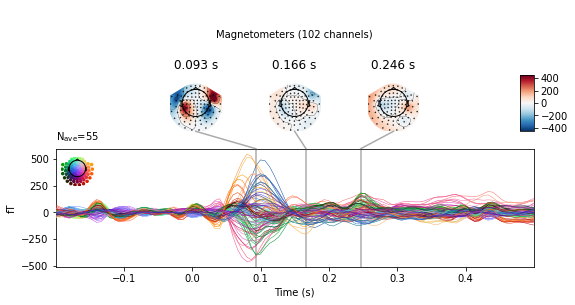

In [17]:
%matplotlib qt 
epochs_stripped.average().plot_joint()

# Calculate the sources
You can use the simple wrapper function "calculate_source" to quickly perform 
all steps in one go! For best results, increase the number of training samples and epochs:  
  
n_samples = 10000  
n_epochs = 100

In [13]:
from esinet.util import calculate_source
source_estimate = calculate_source(epochs_stripped.average(), fwd, batch_size=8, n_samples=2000, n_epochs=30, duration_of_trial=0.1)

c:\Users\Lukas\Documents\projects\esinet\tutorials\..\esinet\util\util.py:222: RuntimeWarning: tmin is not in Evoked time interval. tmin is set to evoked.tmin (-0.199795 sec)
  data_base = evoked.copy().crop(*baseline_span)._data
c:\Users\Lukas\Documents\projects\esinet\tutorials\..\esinet\util\util.py:224: RuntimeWarning: tmax is not in Evoked time interval. tmax is set to evoked.tmax (0.499488 sec)
  data_signal = evoked.copy().crop(*data_span)._data
c:\Users\Lukas\Documents\projects\esinet\tutorials\..\esinet\simulation.py:646: RuntimeWarning: 8.5% of original source space vertices have been omitted, tri-based adjacency will have holes.
Consider using distance-based adjacency or morphing data to all source space vertices.
  adj = mne.spatial_src_adjacency(self.fwd["src"], verbose=0).toarray().astype(int)


Simulate Source
Simulating data based on sparse patches.


100%|██████████| 2000/2000 [00:40<00:00, 49.25it/s]


Converting Source Data to mne.SourceEstimate object


100%|██████████| 2000/2000 [00:01<00:00, 1804.12it/s]


source data shape:  (7498, 15) (7498, 15)

Project sources to EEG...

Create EEG trials with noise...


100%|██████████| 2000/2000 [00:11<00:00, 170.69it/s]



Convert EEG matrices to a single instance of mne.Epochs...
preprocess data
werks3
fit model


c:\Users\Lukas\Envs\esienv\lib\site-packages\scipy\optimize\_minimize.py:783: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


# Plot the result

In [14]:
source_estimate[0].plot(**plot_params)